# heatmap

In [1]:
import os
import keras
from keras.models import load_model
from keras import backend as k
from keras.preprocessing import image
#from keras.applications.vgg16 import preprocessing_input, decode_predictions
import numpy as np
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import tensorflow as tf 
model = tf.keras.models.load_model('/home/gitanjali/Desktop/Deep_learning/DL_2020/assignment1/Q3_PART2_Line_dataset_variation2_saveas_with_architecture.h5')
model.summary()  # As a reminder.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 16)        104       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               4

In [3]:
img_path = "/home/gitanjali/Desktop/Deep_learning/DL_2020/assignment1/line_data/Class20/1_1_4_0_0.jpg"
img = image.load_img(img_path, target_size=(28,28))
x = image.img_to_array(img)

In [4]:
# we add a dimension to transfer our array into a "batch"
# of size (1, 224,224,3)
x = np.expand_dims(x, axis=0)
# final we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [5]:
#run pretrained network on the target image and decode its prediction vector back
preds = model.predict(x)
print('predicted:', preds)
np.argmax(preds[0])
#print(np.argmax[preds[0]])

predicted: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


18

In [6]:
# visualize which part of input/target image are the most hand_made or computer made art
# the convolutional layer

art_output = model.output[:,0]


In [7]:
# this is the output feature map of the 'block5pool' layer,
# last output feature map of 'block5_pool'

last_conv_layer = model.get_layer('conv2d_1')

In [8]:
# this is the gradient of the "hand_made/computer_made" class with regards to
#the output feature map of 'block5pool'
grads = k.gradients(art_output, last_conv_layer.output)[0]
print(grads)

Tensor("gradients/max_pooling2d_1/MaxPool_grad/MaxPoolGrad:0", shape=(None, 11, 11, 32), dtype=float32)


In [9]:
# this is a vector of shape (512,), where each entry
# is the mean intensity of the graident over a specific features map channel
pooled_grads = k.mean(grads, axis=(0, 1, 2))
print(pooled_grads)
print(pooled_grads.shape)

Tensor("Mean:0", shape=(32,), dtype=float32)
(32,)


In [18]:
# this function allows us to access the value of the quantities we just defined:
# 'pooled_grads' and the output feature map of 'block5_conv3'.
#given a sample image
iterate = k.function([model.input], [pooled_grads, last_conv_layer.output[0]])


In [19]:
# these are the values of these two quantities, as numpy array,
# given our sample image
pooled_grads_value, conv_layer_output_value = iterate([x])
print(conv_layer_output_value.shape) # 7,7,512
print(pooled_grads_value.shape)

(11, 11, 32)
(32,)


In [20]:
# we multiply the each channel in the feature map array
# by "how important this channel is" with regards to the image class
# don't know why but it does not work with 512 number as they are the total number of filters for the layer
for i in range(31):
	conv_layer_output_value[:, :, i] *=pooled_grads_value[i]
# the channel-wise mean of the resulting feature map
# is our heatmap of class activation

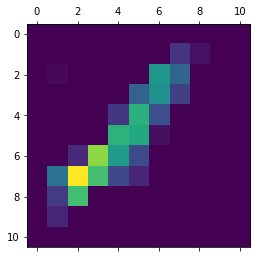

In [23]:
heatmap = np.mean(conv_layer_output_value, axis=-1)

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
#print(heatmap)
plt.matshow(heatmap)
plt.show()

In [24]:
import cv2

#we use cv2 to load the original image
img = cv2.imread(img_path)
# we resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
#we convert the heatmap to RGB
heatmap = np.uint8(255*heatmap)
# we apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 1.2 +img
#save the image to disk
cv2.imwrite('/home/gitanjali/Desktop/feature_map.jpg', superimposed_img)


True

In [27]:
cv2.imshow("output",superimposed_img)